# Quadrupole scan with filter analysis
## Simple script to open JSON and pickle data

In [1]:
import jpype
jpype.startJVM(jpype.getDefaultJVMPath())

In [43]:
from cpymad.madx import Madx
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
import glob
import json
import pybt
from pybt.tools.parsers import read_twiss_file
from pybt.myjson.encoder import myJSONDecoder
from os import walk
import skimage
from skimage import filters
from scipy import integrate
from matplotlib.pyplot import cm
import pickle
from scipy.optimize import curve_fit

def gaussian_function(x, a, I, mu, sig):
    return a + I / np.sqrt(2 * np.pi * sig ** 2) * np.exp(-(x - mu) ** 2 / 2. / sig ** 2)

def do_gaussian_fit(x,y):
    mu = np.average(x, weights=np.abs(y - np.min(y)))
    sigma = np.sqrt(np.average(x**2, weights=np.abs(y - np.min(y))) - mu**2)
    p0 = [y.min(), (np.max(y) - np.min(y)) * np.sqrt(2 * np.pi * sigma**2), mu, sigma]
    popt, pcov = curve_fit(gaussian_function, x, y, p0=p0, maxfev=1000) # maxfev is the number of tries it does the fit
    return popt, pcov

def create_elliptical_mask(h, w, center=None, radius=None, a=None, b=None):

    if center is None: # use the middle of the image
        center = (int(w/2), int(h/2))
    if radius is None: # use the smallest distance between the center and image walls
        radius = min(center[0], center[1], w-center[0], h-center[1])

    Y, X = np.ogrid[:h, :w]
    dist_from_center = np.sqrt( ((X - center[0])**2)/(a**2) + ((Y-center[1])**2)/(b**2) )

    mask = dist_from_center <= radius
    return mask

# Create a Dataframe will all data

In [44]:
pwd

'/afs/cern.ch/work/e/eljohnso/public/quad-scan-east'

In [45]:
start_path = "/afs/cern.ch/work/e/eljohnso/public/quad-scan-east/"
end_path = "quad_scan_east_dump_with_filters_data"
mypath = start_path+"/"+end_path

f = []
for (dirpath, dirnames, filenames) in walk(mypath):
    f.extend(filenames)
    break

In [46]:
for dirname in dirnames:
    print (dirname)

quad_scan_east_dump_with_filters_2022_06_27_15h05m03s
quad_scan_east_dump_with_filters_2022_06_27_15h08m32s
quad_scan_east_dump_with_filters_2022_06_27_15h22m30s


In [47]:
sorted(dirnames)

['quad_scan_east_dump_with_filters_2022_06_27_15h05m03s',
 'quad_scan_east_dump_with_filters_2022_06_27_15h08m32s',
 'quad_scan_east_dump_with_filters_2022_06_27_15h22m30s']

In [48]:
last_folder_created = sorted(dirnames)[-1]
last_folder_created

'quad_scan_east_dump_with_filters_2022_06_27_15h22m30s'

In [49]:
filename = last_folder_created+"/"+last_folder_created
filename

'quad_scan_east_dump_with_filters_2022_06_27_15h22m30s/quad_scan_east_dump_with_filters_2022_06_27_15h22m30s'

In [50]:
import json
 
# Opening JSON file
f = open(end_path+"/"+filename+".json")
 
# returns JSON object as
# a dictionary
data = json.load(f)

In [52]:
data[3]

{'F61.QFN01/MEAS.PULSE#VALUE': [624.0804443359375,
  624.0849609375,
  624.0799560546875,
  624.08056640625,
  624.0809936523438,
  624.0780029296875,
  624.0782470703125,
  624.0787353515625,
  624.0782470703125,
  624.0872802734375,
  624.0811157226562,
  624.0853271484375,
  624.081298828125,
  624.083251953125,
  624.0838012695312,
  624.08154296875,
  624.0775146484375,
  624.08251953125,
  624.078369140625,
  624.076171875,
  624.0840454101562,
  624.08349609375,
  624.079345703125,
  624.0827026367188,
  624.080322265625,
  624.084716796875,
  624.0855102539062,
  624.0821533203125],
 'F61.QDN02/MEAS.PULSE#VALUE': [405.9347229003906,
  405.931884765625,
  405.9324951171875,
  405.9328308105469,
  405.9332275390625,
  405.93109130859375,
  405.9346923828125,
  405.9336853027344,
  405.939453125,
  405.9338073730469,
  405.9311218261719,
  405.92864990234375,
  405.9318542480469,
  405.9331359863281,
  405.93353271484375,
  405.9322814941406,
  405.93212890625,
  405.9328308105469

In [53]:
btv_data_image["imagePositionSet2"]

NameError: name 'btv_data_image' is not defined

In [95]:
image = data[2]["F61D.BTV010/Image"][0]["imageSet"]["data"][0]
image = np.array(image)

In [96]:
pixel_y = len(data[2]["F61D.BTV010/Image"][0]["imagePositionSet2"]["data"][0])
pixel_y

264

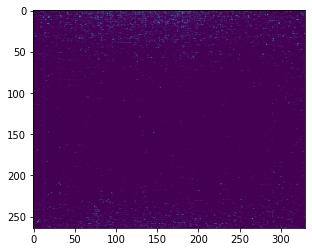

In [107]:
reshaped_image = image.reshape(pixel_y, -1)
reshaped_image = reshaped_image/4095
fig, ax = plt.subplots()
ax.imshow(reshaped_image)

In [98]:
med_filter_image = filters.median(reshaped_image, np.ones((3, 3)))
fig, ax = plt.subplots()
ax.imshow(med_filter_image)

In [111]:
unique, counts = np.unique(med_filter_image, return_counts=True)
my_dict = dict(zip(unique, counts))
try:
    saturation_pixels = my_dict[1]
    if saturation_pixels >= 50:
        print ("saturation high")
    if saturation_pixel < 50:
        print ("saturation low")
except:
    print("no saturation")

no saturation


In [110]:
my_dict

{0.0: 80539,
 0.0002442002442002442: 666,
 0.0004884004884004884: 654,
 0.0007326007326007326: 606,
 0.0009768009768009768: 565,
 0.001221001221001221: 572,
 0.0014652014652014652: 505,
 0.0017094017094017094: 521,
 0.0019536019536019536: 437,
 0.002197802197802198: 375,
 0.002442002442002442: 347,
 0.002686202686202686: 248,
 0.0029304029304029304: 248,
 0.0031746031746031746: 223,
 0.003418803418803419: 165,
 0.003663003663003663: 149,
 0.003907203907203907: 106,
 0.004151404151404151: 46,
 0.004395604395604396: 26,
 0.00463980463980464: 17,
 0.004884004884004884: 31,
 0.005128205128205128: 12,
 0.005372405372405372: 12,
 0.005616605616605617: 10,
 0.005860805860805861: 13,
 0.006105006105006105: 3,
 0.006349206349206349: 2,
 0.006593406593406593: 1,
 0.006837606837606838: 1,
 0.007326007326007326: 4,
 0.00757020757020757: 4,
 0.007814407814407814: 4,
 0.00805860805860806: 1,
 0.008791208791208791: 1,
 0.009523809523809525: 1,
 0.013431013431013432: 1,
 0.016361416361416362: 4}

In [113]:
current1 = np.linspace(500, 400, 20)
current1

array([500.        , 494.73684211, 489.47368421, 484.21052632,
       478.94736842, 473.68421053, 468.42105263, 463.15789474,
       457.89473684, 452.63157895, 447.36842105, 442.10526316,
       436.84210526, 431.57894737, 426.31578947, 421.05263158,
       415.78947368, 410.52631579, 405.26315789, 400.        ])

In [115]:
for i in range(len(current1)):
    print(f"Setting F61.QFN01/REF.PULSE.AMPLITUDE#VALUE to: {round(current1[i], 3)}")

Setting F61.QFN01/REF.PULSE.AMPLITUDE#VALUE to: 500.0
Setting F61.QFN01/REF.PULSE.AMPLITUDE#VALUE to: 494.737
Setting F61.QFN01/REF.PULSE.AMPLITUDE#VALUE to: 489.474
Setting F61.QFN01/REF.PULSE.AMPLITUDE#VALUE to: 484.211
Setting F61.QFN01/REF.PULSE.AMPLITUDE#VALUE to: 478.947
Setting F61.QFN01/REF.PULSE.AMPLITUDE#VALUE to: 473.684
Setting F61.QFN01/REF.PULSE.AMPLITUDE#VALUE to: 468.421
Setting F61.QFN01/REF.PULSE.AMPLITUDE#VALUE to: 463.158
Setting F61.QFN01/REF.PULSE.AMPLITUDE#VALUE to: 457.895
Setting F61.QFN01/REF.PULSE.AMPLITUDE#VALUE to: 452.632
Setting F61.QFN01/REF.PULSE.AMPLITUDE#VALUE to: 447.368
Setting F61.QFN01/REF.PULSE.AMPLITUDE#VALUE to: 442.105
Setting F61.QFN01/REF.PULSE.AMPLITUDE#VALUE to: 436.842
Setting F61.QFN01/REF.PULSE.AMPLITUDE#VALUE to: 431.579
Setting F61.QFN01/REF.PULSE.AMPLITUDE#VALUE to: 426.316
Setting F61.QFN01/REF.PULSE.AMPLITUDE#VALUE to: 421.053
Setting F61.QFN01/REF.PULSE.AMPLITUDE#VALUE to: 415.789
Setting F61.QFN01/REF.PULSE.AMPLITUDE#VALUE to: 41

In [119]:
x1 = np.linspace(0,2,3)
x1

array([0., 1., 2.])

In [122]:
x1 = np.repeat(x1,3)
x1

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 2., 2., 2., 2., 2., 2., 2., 2., 2.])